In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import cv2
import os
import re

## Exploratory Data Analysis

### Checking label, label name and image-name in data.csv

Import from data.csv, which consist the image name, corresponding label and label name, name dataframe as mj_df

In [6]:
mj_df = pd.read_csv("data.csv")
print('Shape of data:', mj_df.shape)

display(mj_df.head())

Shape of data: (700, 3)


,image-name,label,label-name
0,1.jpg,38,bonus-winter
1,2.jpg,26,characters-8
2,3.jpg,9,dots-9
3,4.jpg,36,bonus-summer
4,5.jpg,28,honors-east



It is noted that the "image-name" and "label-name" are with hyphen, change them to underscore to prevent error when calling df.XXX-XXX

In [7]:
mj_df = mj_df.rename(columns=lambda x: re.sub('-', '_', x))

Afterwards, add a new column of image path to mj_df

In [8]:
image_path = os.path.join('images','{}')
mj_df['image_path'] = mj_df['image_name'].apply(lambda x :image_path.format(x))
mj_df.head()

,image_name,label,label_name,image_path
0,1.jpg,38,bonus-winter,images\1.jpg
1,2.jpg,26,characters-8,images\2.jpg
2,3.jpg,9,dots-9,images\3.jpg
3,4.jpg,36,bonus-summer,images\4.jpg
4,5.jpg,28,honors-east,images\5.jpg


Check if the data is consistent, including label and label_name

Text(0.5, 0, 'Label_Name')

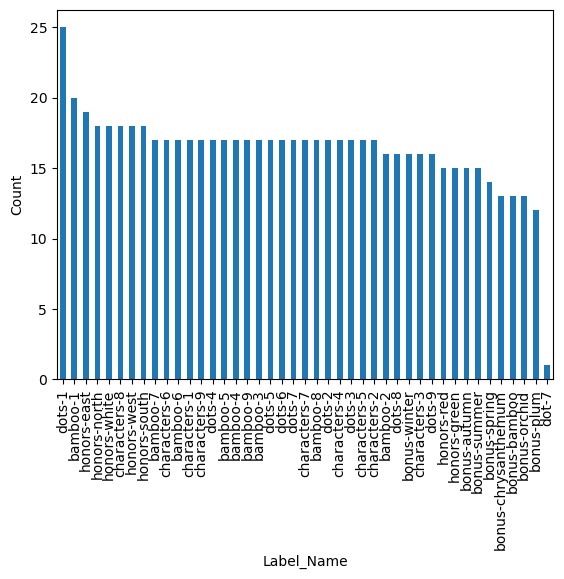

In [9]:
df_barchart = mj_df['label_name'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label_Name",fontsize=10)

It is noted that there is a typo in one of the label_name, instead of "dot-7" it should be "dots-7", replace accordingly

In [10]:
mj_df['label_name'] = mj_df['label_name'].replace({'dot-7': 'dots-7'})

Text(0.5, 0, 'Label_Name')

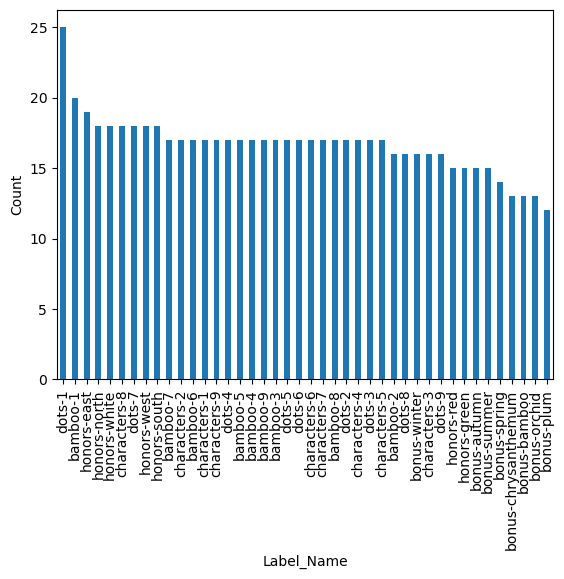

In [11]:
df_barchart = mj_df['label_name'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label_Name",fontsize=10)

Text(0.5, 0, 'Label')

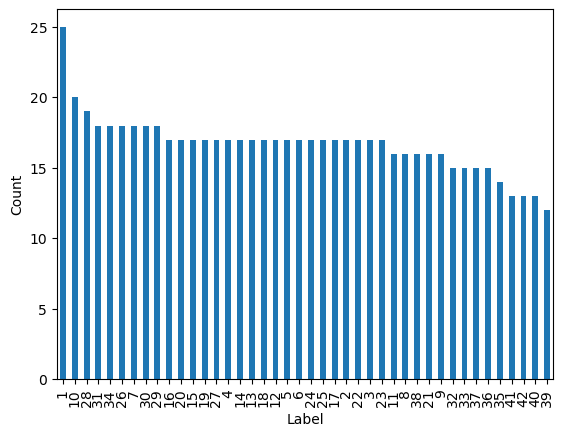

In [12]:
df_barchart = mj_df['label'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label",fontsize=10)

It is noted the label starts at 1 instead of 0, hence subtract 1 from labels to facilitate classification by tensorflow

In [13]:
mj_df['label'] -= 1
mj_df.head()
print('mj_df Label starts at:', min(mj_df['label']), 'after subtract.')


mj_df Label starts at: 0 after subtract.


Then check if the label and label_name are unique pair.

In [14]:
mj_df.groupby(['label', 'label_name']).size()

label  label_name         
0      dots-1                 25
1      dots-2                 17
2      dots-3                 17
3      dots-4                 17
4      dots-5                 17
5      dots-6                 17
6      dots-7                 18
7      dots-8                 16
8      dots-9                 16
9      bamboo-1               20
10     bamboo-2               16
11     bamboo-3               17
12     bamboo-4               17
13     bamboo-5               17
14     bamboo-6               17
15     bamboo-7               17
16     bamboo-8               17
17     bamboo-9               17
18     characters-1           17
19     characters-2           17
20     characters-3           16
21     characters-4           17
22     characters-5           17
23     characters-6           17
24     characters-7           17
25     characters-8           18
26     characters-9           17
27     honors-east            19
28     honors-south           18
29     honors-we

The label and label name pairs are unique, set num_classes as unique labels (42 classes)

In [15]:
num_classes = mj_df['label'].nunique()
print(num_classes, 'number of classes')

42 number of classes


### Loading and preprocessing of images

Afterwards, we would like to load the images into a list with cv2, at the same time check the aspect ratio of the photos.
Since data augmentation would be performed, the images shall be in same aspect ratio for image resize.

In [16]:
images= []
for index, row in mj_df[['image_path']].iterrows():
    img = cv2.imread(row[0], cv2.IMREAD_UNCHANGED)
    height, width = img.shape[:2]
    # Save the dimensions to a new column in the DataFrame
    mj_df.loc[index, 'width'] = width
    mj_df.loc[index, 'height'] = height
    if img is not None:
        images.append(img)
#calculate the image aspect ratio
mj_df['ratio'] = mj_df['width']/mj_df['height']

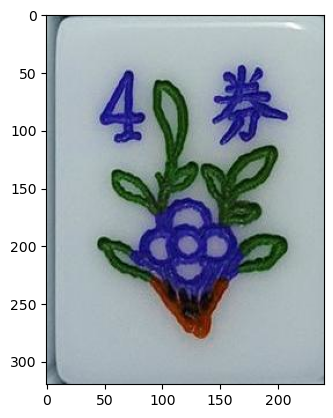

In [17]:
#Display of sample image
plt.imshow(images[0].astype("uint8"))

Most of the images have aspect ratio of 3:4, hence try to find ones that are not 3:4.

In [18]:
mj_df[mj_df['ratio'] != 0.75]

,image_name,label,label_name,image_path,width,height,ratio
640,641.jpg,28,honors-south,images\641.jpg,136.0,184.0,0.739130
687,688.jpg,39,bonus-orchid,images\688.jpg,89.0,116.0,0.767241


Noting two of the images don't have a ratio of 0.75, amend to size to allow uniform resize in data augmentation

In [19]:
images[640] = images[640][0:180, 0:135]
mj_df.loc[640, 'width'] = 135
mj_df.loc[640, 'height'] = 180
images[688] = images[688][0:116, 0:87]
mj_df.loc[688, 'width'] = 87
mj_df.loc[688, 'height'] = 116
print('shape of images[640]:',images[640].shape[:2])
print('shape of images[688]:',images[688].shape[:2])
mj_df['ratio'] = mj_df['width']/mj_df['height']

shape of images[640]: (180, 135)
shape of images[688]: (116, 87)


In [20]:
display(mj_df.loc[[640,688]])

,image_name,label,label_name,image_path,width,height,ratio
640,641.jpg,28,honors-south,images\641.jpg,135.0,180.0,0.75
688,689.jpg,40,bonus-chrysanthemum,images\689.jpg,87.0,116.0,0.75


Since tensor can only take rectangular array, resize the images to 224x224 with cv2.resize

In [21]:
img_height = 224
img_width = 224
num_classes = 42

In [23]:
images_resized = []
for image in images:
    img_resized = cv2.resize(image, dsize=(img_height, img_width), interpolation=cv2.INTER_NEAREST)
    images_resized.append(img_resized)
print('Resized image shape:',images_resized[0].shape)

Resized image shape: (224, 224, 3)


Load the resized images and labels into np.array

In [24]:
img_arr = np.array(images_resized, dtype=object)
label = np.array(mj_df['label'])
print('img_arr shape:',img_arr.shape)
print('label shape:', label.shape)

img_arr shape: (700, 224, 224, 3)
label shape: (700,)


In [84]:
indices = np.arange(label.shape[0])

In [88]:
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=320, stratify=label)
indices_train.shape

(560,)

<br>
Since each label has limited number of sample (e.g. for label 38 bonus-plum  there's only 12 samples), it is preferred to use stratified split in dataset. Use StratifiedKFold to separate data into 4 sets for model training.

(420, 224, 224, 3)
(420, 224, 224, 3)
(420, 224, 224, 3)
(420, 224, 224, 3)


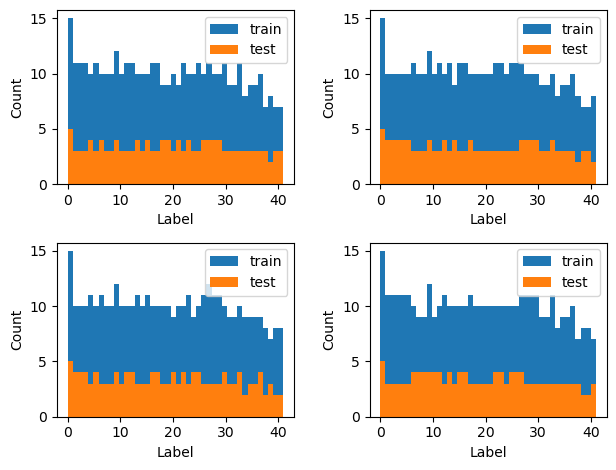

In [89]:
kfold_bar=[]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=320)
fig = plt.figure()
n=0
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=320, stratify=label)
img_train, X_test = img_arr[indices_train], img_arr[indices_test]
label_train, y_test = label[indices_train], label[indices_test]
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    print(X_train.shape)
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    n += 1
    fig.tight_layout()
    plt.subplot(2, 2, n)
    plt.hist(label_train[train_index], label="train", bins = num_classes)
    plt.hist(label_train[val_index], label="test", bins = num_classes)
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.legend(loc=1)
   #print(

### Visualize images and corresponding label

In [71]:
def display_image(images,labels, no_img):
    for n, (image, label) in enumerate(zip(images[:no_img],labels[:no_img])):
        plt.subplot(no_img,1, n+1)
        #image is a batch of 16 images, get the first image from the batch
        plt.imshow(image.astype("uint8"))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        #label is a batch of 16 one-hot encoded feature, get the first one from the batch
        plt.xlabel('Label: '+ str(label))
    plt.show()

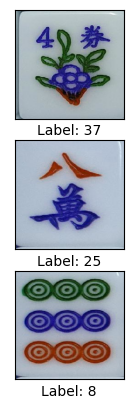

In [72]:
display_image(img_arr, label,3)

## Tensor model setup

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

### Create base model with Mobilenet V2

In [29]:
#Specifying the include_top=False argument, so that the network doesn't include the classification layers at the top
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')


In [30]:
#Set base_model as not trainable, which prevents the weights in a given layer from being updated during training, to allow extraction of features
base_model.trainable = False

In [31]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.summary()

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )     

### Define classification layer, second last layer (Conv2D), and input processing/ augmentation

In [32]:
#Use tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

In [33]:
#Define second last layer, a 2D convolution layer, which generates an output shape of (batch,7,7,42)
Conv2D = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=(3, 3),padding='same',use_bias=True,kernel_initializer='glorot_uniform')

In [34]:
#Convert features into a single prediction per image,with 42 classes
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [35]:
#Define data normalization with tf.keras.applications.mobilenet_v2.preprocess_input and data augmentation
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_augmentation = tf.keras.Sequential([
  layers.RandomZoom(.2,.2),
  layers.RandomRotation(0.3),
  layers.RandomFlip("horizontal_and_vertical"),  
  layers.RandomContrast(0.3),
  #layers.RandomTranslation(0.3,0.3)
])

In [36]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
print(x.shape)
x = preprocess_input(x)
print(x.shape)
x = base_model(x, training=False)
print(x.shape)
#x = Conv2D(x)
x = global_average_layer(x)
print(x.shape)
#x = tf.keras.layers.Flatten()(x)
#print(x.shape)
#x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

(None, 224, 224, 3)
(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)
Output has a dimension of: (None, 42)


## Building model by chaining together preprocessing, augmentation, base model and feature extractor layer, then compile model

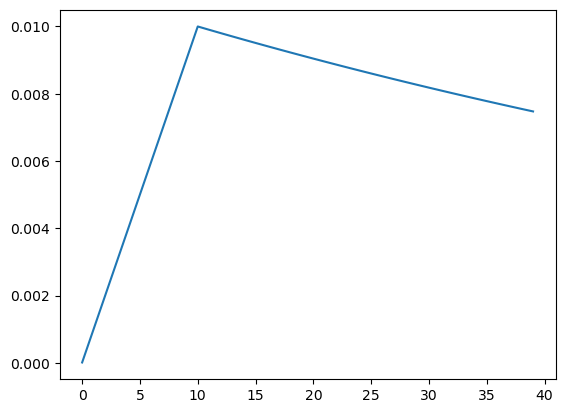

In [37]:
def scheduler(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_MIN = 1e-5
    LR_RAMPUP_EPOCHS = 10
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .99

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN

    return lr
cosine_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=False)
plt.plot([scheduler(x) for x in range(40)]);


In [38]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'] )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

## Model Training

initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_ds)

In [39]:
batch_size = 16

In [40]:
total_epochs = 0
acc = []
val_acc = []
loss = []
val_loss = []
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #place to function too
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(train_ds.cardinality().numpy())
    epochs = 10
    print('Before', total_epochs)
    history = model.fit(train_ds,  
                        validation_data=val_ds,
                        epochs = total_epochs + epochs,
                        initial_epoch= total_epochs
                        )
    total_epochs += epochs
    print('After', total_epochs)
#    else:
#        history = model.fit(train_ds,  
 #                           validation_data=test_ds,
 #                           epochs = epochs,
  #                          initial_epoch=history.epoch[-1]
#    )
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']

    loss += history.history['loss']
    val_loss += history.history['val_loss']

27
Before 0
Epoch 1/10
27/27 [==============================] - 23s 529ms/step - loss: 3.8833 - accuracy: 0.0905 - val_loss: 3.0809 - val_accuracy: 0.1786
Epoch 2/10
27/27 [==============================] - 12s 454ms/step - loss: 2.4757 - accuracy: 0.3405 - val_loss: 2.5312 - val_accuracy: 0.2643
Epoch 3/10
27/27 [==============================] - 12s 454ms/step - loss: 1.9296 - accuracy: 0.4786 - val_loss: 2.2969 - val_accuracy: 0.3643
Epoch 4/10
27/27 [==============================] - 12s 443ms/step - loss: 1.5974 - accuracy: 0.5571 - val_loss: 2.1208 - val_accuracy: 0.3857
Epoch 5/10
27/27 [==============================] - 13s 476ms/step - loss: 1.4269 - accuracy: 0.5952 - val_loss: 1.9986 - val_accuracy: 0.4000
Epoch 6/10
27/27 [==============================] - 12s 448ms/step - loss: 1.2830 - accuracy: 0.6500 - val_loss: 1.9599 - val_accuracy: 0.3929
Epoch 7/10
27/27 [==============================] - 12s 436ms/step - loss: 1.1410 - accuracy: 0.6857 - val_loss: 1.8914 - val_accu

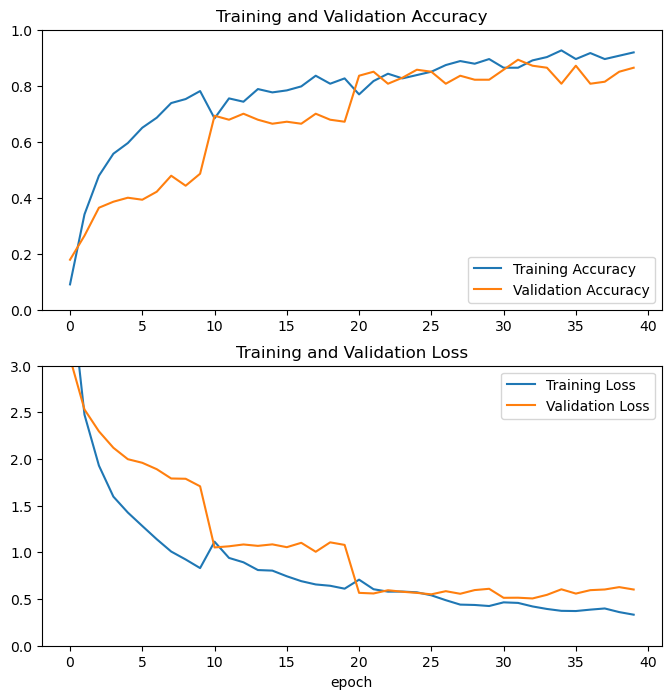

In [41]:
#Learning curve of model training + fine tuning
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1])
          #plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([epochs-1,epochs-1])
         #plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
y_pred = model.predict(X_test.astype('f'))
y_pred = np.argmax(y_pred, axis=1)

5/5 [==============================] - 8s 603ms/step


In [44]:
cr = classification_report(y_test, y_pred, output_dict=True)#, target_names=np.argmax(y_true, axis = 1)
print('Macro f1 score:', f1_score(y_test, y_pred, average = 'macro'))
result = pd.DataFrame.from_dict(cr).T
display(result)
#result[result['f1-score'] < 0.5]

Macro f1 score: 0.613718820861678


C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,5.000000
1,0.750000,1.000000,0.857143,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,1.000000,0.666667,0.800000,3.000000
4,1.000000,0.666667,0.800000,3.000000
5,0.166667,0.333333,0.222222,3.000000
6,0.500000,0.500000,0.500000,4.000000
7,0.500000,0.666667,0.571429,3.000000
8,0.000000,0.000000,0.000000,3.000000
9,0.400000,0.500000,0.444444,4.000000


The model performed the worst on label 23 and 38, with f1-score of 0, take a look on the corresponding images.

## Error Analysis

# from sklearn.metrics import classification_report

#Predict y_pred with model
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)
unique_class = np.unique(y_pred)
print('No. of unique class predicted: ' + str(len(unique_class)))
print('y_pred:\n', y_pred)
#Verify against y_true in val_ds
y_true = np.concatenate([y for (x, y) in val_ds], axis=0)
print('y_true:\n', np.argmax(y_true, axis = 1))
cr = classification_report(np.argmax(y_true, axis=1), y_pred, output_dict=True)#, target_names=np.argmax(y_true, axis = 1)

In [54]:
cr = classification_report(np.argmax(X_test, axis=1), y_test, output_dict=True)
result = pd.DataFrame.from_dict(cr).T
display(result)

ValueError: Classification metrics can't handle a mix of unknown and multilabel-indicator targets

## Model fine-tuning

In [54]:
#Set model to trainable, and check the number of layers in base model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [55]:
#Training
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [56]:
#fine_tune_epochs = 30
#total_epochs =  epochs + fine_tune_epochs

for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #place to function too
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    print(train_ds.cardinality().numpy())
    epochs = 10
    print('Before', total_epochs)
    history_fine = model.fit(train_ds,  
                        validation_data=val_ds,
                        epochs = total_epochs + epochs,
                        initial_epoch= total_epochs
                        )
    total_epochs += epochs


27
Before 80
Epoch 81/90
27/27 [==============================] - 77s 2s/step - loss: 0.0951 - accuracy: 0.9619 - val_loss: 0.2305 - val_accuracy: 0.9357
Epoch 82/90
27/27 [==============================] - 53s 2s/step - loss: 0.0917 - accuracy: 0.9690 - val_loss: 0.2035 - val_accuracy: 0.9500
Epoch 83/90
27/27 [==============================] - 52s 2s/step - loss: 0.1014 - accuracy: 0.9643 - val_loss: 0.2086 - val_accuracy: 0.9429
Epoch 84/90
27/27 [==============================] - 52s 2s/step - loss: 0.0785 - accuracy: 0.9738 - val_loss: 0.2680 - val_accuracy: 0.9071
Epoch 85/90
27/27 [==============================] - 54s 2s/step - loss: 0.1058 - accuracy: 0.9738 - val_loss: 0.2295 - val_accuracy: 0.9286
Epoch 86/90
27/27 [==============================] - 51s 2s/step - loss: 0.1083 - accuracy: 0.9762 - val_loss: 0.2218 - val_accuracy: 0.9429
Epoch 87/90
27/27 [==============================] - 51s 2s/step - loss: 0.0751 - accuracy: 0.9857 - val_loss: 0.2737 - val_accuracy: 0.9214


In [57]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

In [61]:
y_pred_fine = model.predict(X_test.astype('f'))
y_pred_fine = np.argmax(y_pred_fine, axis=1)


5/5 [==============================] - 3s 540ms/step


In [63]:
cr_fine = classification_report(y_test , y_pred_fine, output_dict=True)
rpt_fine = pd.DataFrame.from_dict(cr_fine).T
display(rpt_fine[rpt_fine['f1-score'] < 0.5])

C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Justin\anaconda3\envs\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
5,0.333333,0.333333,0.333333,3.0
24,0.400000,0.500000,0.444444,4.0
26,0.000000,0.000000,0.000000,3.0
37,0.200000,0.666667,0.307692,3.0
38,0.000000,0.000000,0.000000,2.0
40,0.333333,0.333333,0.333333,3.0
41,0.500000,0.333333,0.400000,3.0


In [78]:
f1_list = rpt_fine.index[rpt_fine['f1-score'] < 0.5].astype("uint8").tolist()

In [83]:
y_test

array([ 8,  0, 18, 30, 24,  0, 25, 34,  2, 40, 28, 30, 28,  6, 36, 15, 37,
       17,  4, 15, 24, 19, 39, 33, 39, 21, 41, 33, 37, 26, 14, 39, 21, 29,
       35, 30, 41, 27, 38,  4, 10, 11, 24, 25, 20, 34, 14, 29, 18, 21, 22,
        9, 21, 27,  7, 38, 12, 24, 12,  5, 13, 30,  6, 15, 18,  0, 32, 16,
       23,  3,  9, 33, 33, 37,  6,  4,  1, 11, 27, 23,  3, 31, 26, 29,  1,
       23, 26,  3, 17, 28, 35,  9,  7, 31,  5,  0, 20,  0, 22, 40,  6, 36,
       14, 28,  8, 19, 10, 25, 17, 27, 20, 10,  7, 34, 11,  8, 36, 12,  9,
       19, 13, 32, 14, 16, 32,  2, 35,  1, 18, 31, 13, 40, 16, 19,  2, 25,
        5, 29, 22, 41], dtype=int64)

In [80]:
mj_df[['label'] in f1_list]

KeyError: False

In [ ]:
display_image(img_arr, label,3)

__Fine tuning from layer 90 onwards with 20 epoch has improved the val accuracy from ~0.7 to ~0.8.__

## Display of true and predicted class examples

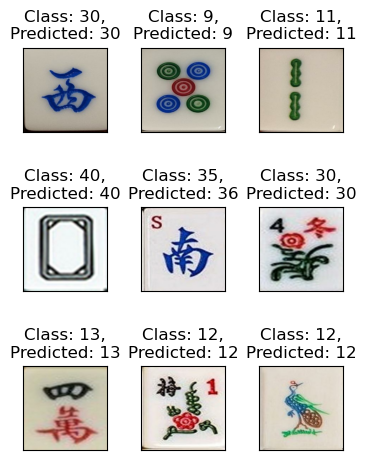

In [31]:
for n, (image, label) in enumerate(val_ds.take(9)):
    plt.subplot(3,3,n+1)
    plt.imshow(image[1].numpy().astype("uint8"))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.6,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    plt.title("Class: {},\nPredicted: {}".format(np.argmax(label), y_pred_fine[n*batch_size]))
plt.show()


## Conclusion

The fine tuned Mobilenet_V2 model demonstrated its ability to classify mahjong class, with accuracy of ~0.8 on validation set. The image dataset has a relatively small size of 700 images and 42 classes, which could lead to insufficient data for training, even with data augmentation. Overfitting was encoutnered in the earlier stage of development, as the 154 layers Mobilenet_V2 was trained to a small set of data. The model accuracy on validation set has improved significantly after dropout was introduced.